In [1]:
import sys, os
sys.path.append("../model/")
sys.path.append("../datasets/")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from train import getprobs
from EvalTools import *
import numpy as np
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm import tqdm
#import mpl_scatter_density
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"
dataset = 'topdata'

#optional parameters to only evaluate certain models
optional_tag = ''
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if dataset in f and optional_tag in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_Ensemble_topdata_baseline.h5
RESULTS_UQPFIN_MCDO_topdata_baseline.h5
RESULTS_UQPFIN_best_topdata_0.1_baseline.h5
RESULTS_UQPFIN_best_topdata_0.1_massmask200.h5
RESULTS_UQPFIN_best_topdata_0.1_ptmask575.h5
RESULTS_UQPFIN_best_topdata_0_baseline.h5
RESULTS_UQPFIN_best_topdata_nominal_baseline.h5
RESULTS_UQPFIN_best_topdata_nominal_massmask200.h5
RESULTS_UQPFIN_best_topdata_nominal_ptmask575.h5


In [3]:
if dataset == 'topdata':
    true_classes = [0, 1] # 0:QCD, 1:top
    names = ["background", "signal"]
if dataset == 'jetnet':
    true_classes = [0, 1, 2, 3, 4] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['light quarks', 'gluons', 'top quarks', 'W bosons', 'Z bosons']
if dataset == 'jetclass':
    true_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['l_QCD', 'l_Hbb', 'l_Hcc', 'l_Hgg', 'l_H4q', 'l_Hqql', 'l_Zqq', 'l_Wqq', 'l_Tbqq', 'l_Tbl']
if dataset == 'JNqgmerged':
    true_classes = [0, 1, 2, 3] # 0: g/q, 1:t, 2:w, 3:z
    names = ['QCD', 'top quarks', 'W bosons', 'Z bosons']

In [4]:
model_results = {}

for modelname in result_files:
    if 'best' in modelname:
        mname = modelname[20:-3]
    else:
        mname = modelname[15:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    if 'best' in modelname:
        model_results[mname] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:],
                                   'aug': f['aug'][:],
                                   'latents': f['latents'][:]}
    else:
        model_results[mname] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:],
                                   'aug': f['aug'][:]}
    f.close()

In [5]:
all_keys = list(model_results.keys())
all_keys

['Ensemble_topdata_baseline',
 'MCDO_topdata_baseline',
 'topdata_0.1_baseline',
 'topdata_0.1_massmask200',
 'topdata_0.1_ptmask575',
 'topdata_0_baseline',
 'topdata_nominal_baseline',
 'topdata_nominal_massmask200',
 'topdata_nominal_ptmask575']

In [14]:
model2explore = 'jetnet_nominal_baseline'

In [ ]:
_ = plt.scatter(model_results[model2explore]['preds'][:10000], 
                model_results[model2explore]['uncs'][:10000], 
                s=0.8, 
                alpha=0.3, 
                marker='.')

In [ ]:
_ = plt.scatter(model_results[model2explore]['oods'][:10000], 
                model_results[model2explore]['uncs'][:10000], 
                s=0.8, 
                alpha=0.3, 
                marker='.')

In [ ]:
_ = plt.hist2d(model_results[model2explore]['oods'][:10000], 
                model_results[model2explore]['labels'][:10000])
plt.colorbar()

In [ ]:
plt.hist(model_results[model2explore]['labels'][:10000])

In [6]:
tags = []
for modelname in all_keys:
    if "Ensemble" not in modelname and "MCDO" not in modelname:
        continue
    tag = modelname.strip().split('_')[-1]
    if tag not in tags:
        tags.append(tag)
print("\n".join(tags))

baseline


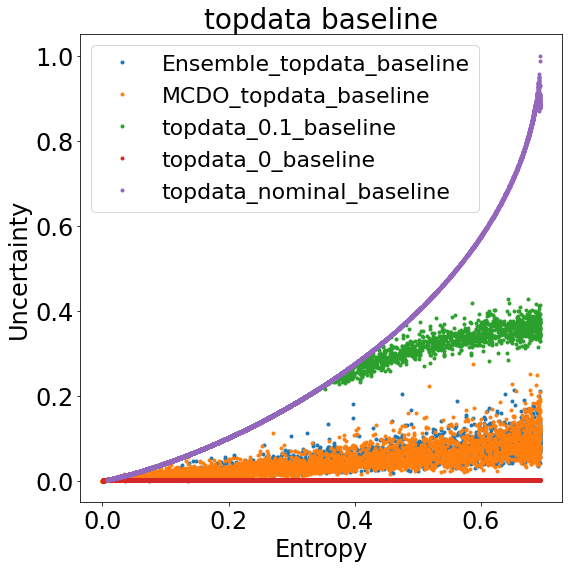

In [60]:
Nsample = 10000

for tag in tags:
    plt.figure(figsize=(8,8))
    
    keys = [k for k in all_keys if tag in k]
    for ii,key in enumerate(keys):
        probs, uncs = model_results[key]['probs'][:Nsample], model_results[key]['uncs'][:Nsample]

        entropy = -np.sum(probs * np.log(probs), axis=1)

        plt.plot(entropy, uncs, linestyle = 'None', marker='.', label=key)



    plt.xlabel('Entropy', fontsize=24)
    plt.ylabel("Uncertainty", fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.title("{} {}".format(dataset, tag), fontsize = 28)
    plt.legend(fontsize = 22)
    plt.tight_layout()
    plt.show()

In [63]:
model_results['Ensemble_topdata_baseline']

{'labels': array([0, 0, 0, ..., 0, 1, 1]),
 'preds': array([0, 0, 0, ..., 1, 1, 1]),
 'maxprobs': array([0.984093  , 0.999891  , 0.9999987 , ..., 0.73820215, 0.9339358 ,
        0.9984333 ], dtype=float32),
 'sums': array([], dtype=float64),
 'oods': array([False, False, False, ..., False, False, False]),
 'uncs': array([8.1267720e-03, 9.2357164e-05, 2.8914089e-06, ..., 5.2588008e-02,
        1.2597959e-02, 9.7205205e-04], dtype=float32),
 'probs': array([[9.84093010e-01, 1.59070101e-02],
        [9.99890983e-01, 1.09033615e-04],
        [9.99998689e-01, 1.40115139e-06],
        ...,
        [2.61797845e-01, 7.38202155e-01],
        [6.60641342e-02, 9.33935821e-01],
        [1.56663801e-03, 9.98433292e-01]], dtype=float32)}

Ensemble_topdata_baseline
MCDO_topdata_baseline
topdata_0.1_baseline
topdata_0_baseline
topdata_nominal_baseline


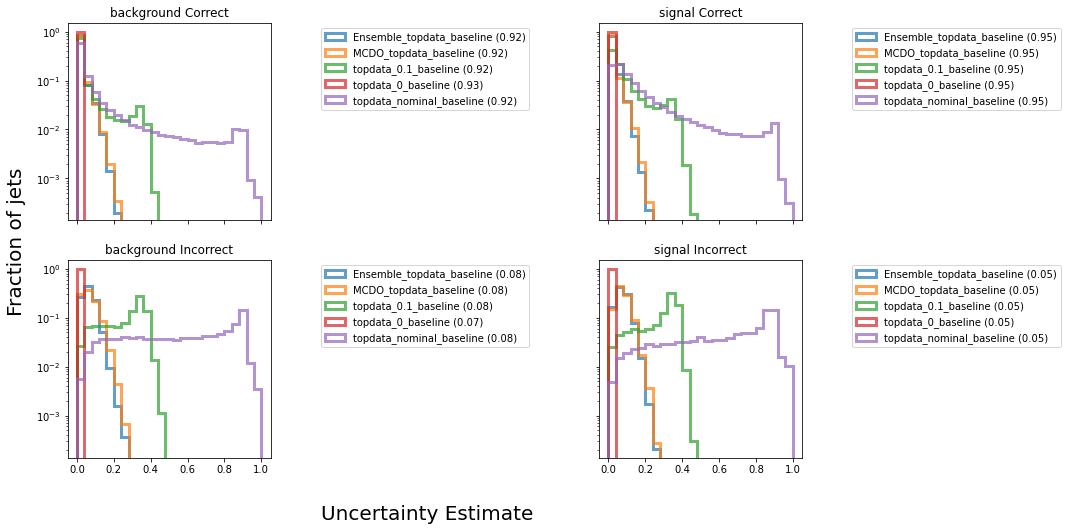

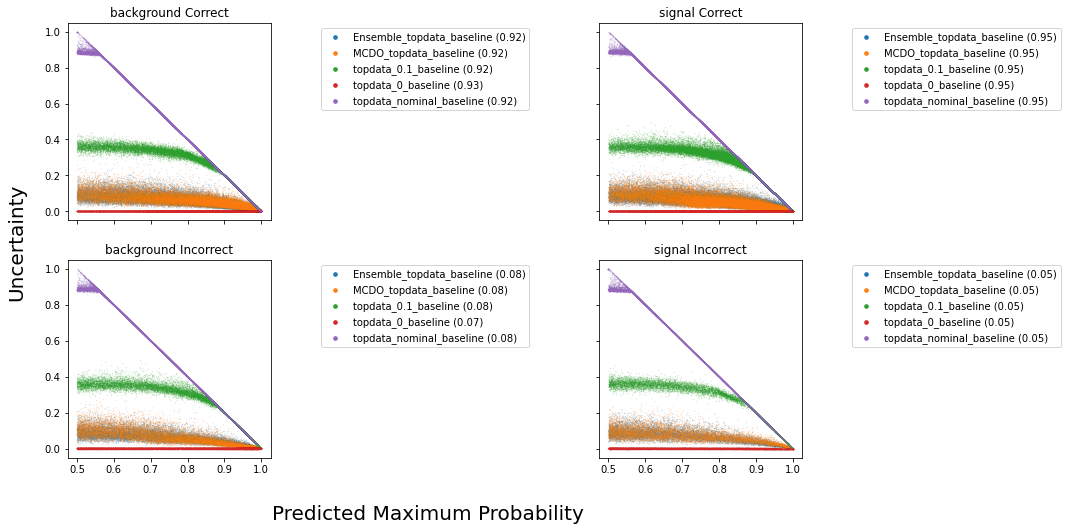

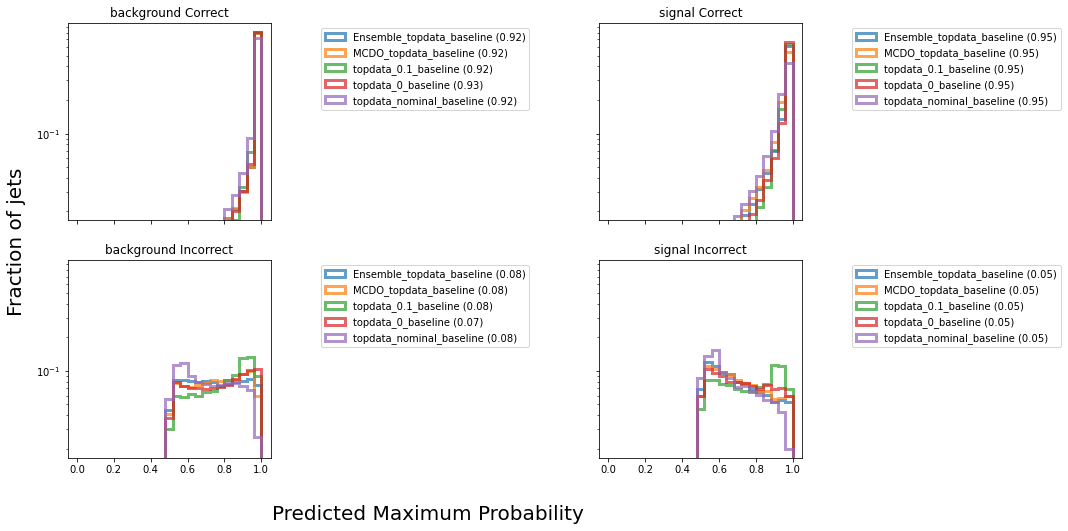

In [7]:
#Amount to shift plots and legends by
n=.1

for tag in tags:
    keys = [k for k in all_keys if tag in k]
    
    Nrows = 2 # predicted as 0->QCD or 1->top
    Ncols = len(true_classes)

    fig, axes = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)
    fig2, axes2 = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)
    fig3, axes3 = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)

    for ii,key in enumerate(keys):
        labels, preds, sums, oods, uncs, probs, maxprobs = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['sums'], model_results[key]['oods'], model_results[key]['uncs'], model_results[key]['probs'], model_results[key]['maxprobs']
        print(key)
        for jj in true_classes:
            all_indices = ((labels == jj)).sum() 
            this_indices_0 = (labels == jj) & (preds == jj)
            this_indices_1 = (labels == jj) & (preds != jj)
            ood = False
            if np.sum(this_indices_0) == 0:
                ood = True
            f0 = this_indices_0.sum()/all_indices
            f1 = this_indices_1.sum()/all_indices
            axes[0, jj].set_title(names[jj] + " Correct")
            axes[1, jj].set_title(names[jj] + " Incorrect")
            axes2[0, jj].set_title(names[jj] + " Correct")
            axes2[1, jj].set_title(names[jj] + " Incorrect")
            axes3[0, jj].set_title(names[jj] + " Correct")
            axes3[1, jj].set_title(names[jj] + " Incorrect")

            if not ood:    
                axes[0, jj].hist(uncs[this_indices_0], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f0), alpha = 0.7, 
                 histtype = 'step', linewidth = 3, weights = (1./len(uncs[this_indices_0])) * np.ones_like(uncs[this_indices_0]))
            axes[1,jj].hist(uncs[this_indices_1], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f1), alpha = 0.7, 
                 histtype = 'step', linewidth = 3, weights = (1./len(uncs[this_indices_1])) * np.ones_like(uncs[this_indices_1]))
            if not ood:
                axes2[0,jj].scatter(maxprobs[this_indices_0], uncs[this_indices_0], label=key + ' ({:.2f})'.format(f0), alpha = 0.3, marker = '.', s = 0.2)
            axes2[1,jj].scatter(maxprobs[this_indices_1], uncs[this_indices_1], label=key + ' ({:.2f})'.format(f1), alpha = 0.3, marker = '.', s = 0.2)

            if not ood:
                axes3[0, jj].hist(maxprobs[this_indices_0], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f0), alpha = 0.7, 
                 histtype = 'step', linewidth = 3, weights = (1./len(uncs[this_indices_0])) * np.ones_like(uncs[this_indices_0]))
            axes3[1,jj].hist(maxprobs[this_indices_1], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f1), alpha = 0.7, 
                 histtype = 'step', linewidth = 3, weights = (1./len(uncs[this_indices_1])) * np.ones_like(uncs[this_indices_1]))
            if jj > 0:
                for k in range(2):
                    box = axes[k,jj].get_position()
                    box.x0 = box.x0 + n*jj
                    box.x1 = box.x1 + n*jj
                    axes[k,jj].set_position(box)
                    box = axes2[k,jj].get_position()
                    box.x0 = box.x0 + n*jj
                    box.x1 = box.x1 + n*jj
                    axes2[k,jj].set_position(box)
                    box = axes3[k,jj].get_position()
                    box.x0 = box.x0 + n*jj
                    box.x1 = box.x1 + n*jj
                    axes3[k,jj].set_position(box)
    for ii,ax in enumerate(list(axes.flatten()) + list(axes3.flatten())  + list(axes2.flatten())):
        leg = ax.legend(bbox_to_anchor=(2.3, 1),loc='upper right',markerscale=16)
        if ii >= 4*Ncols:
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
        else:
            ax.set_yscale('log')
                # lh._legmarker.set_markersize(16)

    fig.supxlabel('Uncertainty Estimate', fontsize = 20, x=0.75)
    fig.supylabel('Fraction of jets', fontsize = 20)
    fig2.supxlabel('Predicted Maximum Probability', fontsize = 20, x=0.75)
    fig2.supylabel('Uncertainty', fontsize = 20)
    fig3.supxlabel('Predicted Maximum Probability', fontsize = 20, x=0.75)
    fig3.supylabel('Fraction of jets', fontsize = 20)

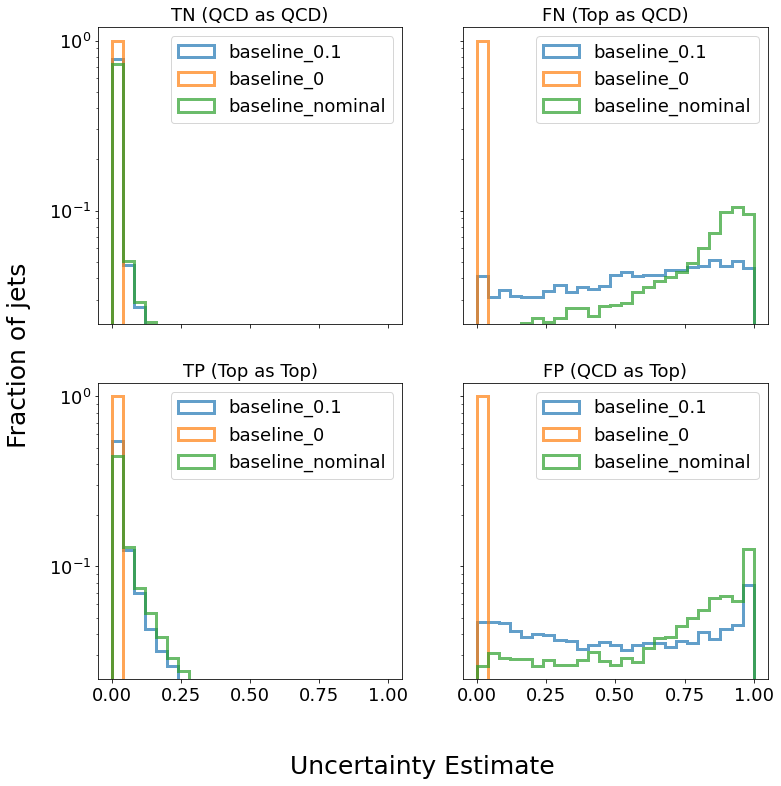

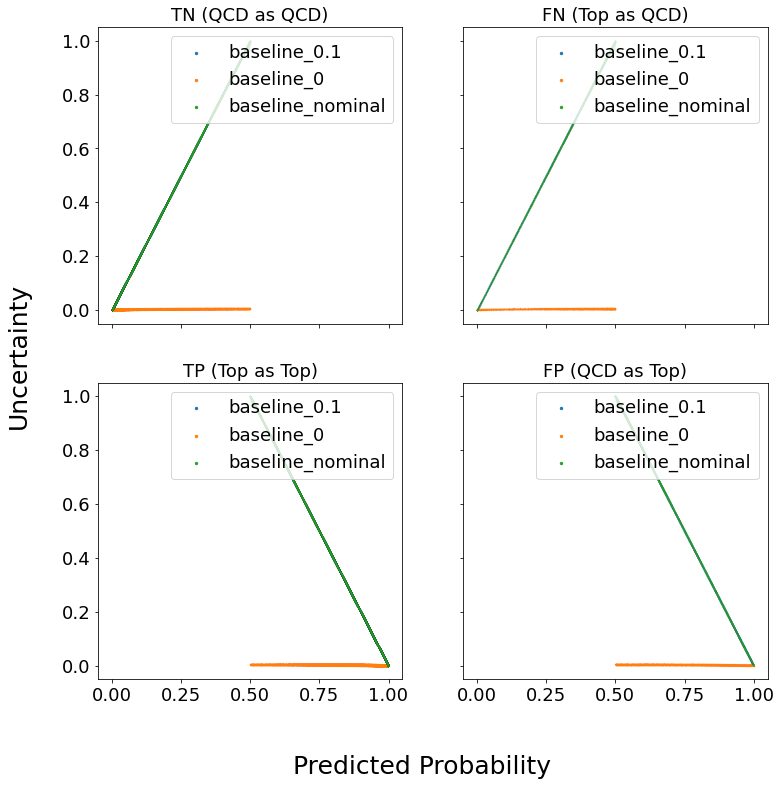

In [16]:
fig, ((tn, fn), (tp, fp)) = plt.subplots(2, 2, figsize=(12,12), sharex = True, sharey = True)

# fig2 = plt.figure(figsize=(12,12))
# tn2 = fig2.add_subplot(2, 2, 1, projection='scatter_density')
# fn2 = fig2.add_subplot(2, 2, 2, projection='scatter_density')
# tp2 = fig2.add_subplot(2, 2, 3, projection='scatter_density')
# fp2 = fig2.add_subplot(2, 2, 4, projection='scatter_density')
#colors = ['red', 'blue','green']
fig2, ((tn2, fn2), (tp2, fp2)) = plt.subplots(2, 2, figsize=(12,12), sharex = True, sharey = True)
for ii,key in enumerate(all_keys):
    labels, preds, sums = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['sums']
    tn_indices = (labels == 0) & (preds < 0.5)
    fn_indices = (labels == 1) & (preds < 0.5)
    tp_indices = (labels == 1) & (preds >= 0.5)
    fp_indices = (labels == 0) & (preds >= 0.5)
    # bkg_indices = labels == 0
    # sig_indices = labels == 1
    
    tn.hist(2./sums[tn_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[tn_indices])) * np.ones_like(sums[tn_indices]))
    fn.hist(2./sums[fn_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[fn_indices])) * np.ones_like(sums[fn_indices]))
    
    tp.hist(2./sums[tp_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[tp_indices])) * np.ones_like(sums[tp_indices]))
    fp.hist(2./sums[fp_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[fp_indices])) * np.ones_like(sums[fp_indices]))
    
    tn2.scatter(preds[tn_indices], 2./sums[tn_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    fn2.scatter(preds[fn_indices], 2./sums[fn_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    tp2.scatter(preds[tp_indices], 2./sums[tp_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    fp2.scatter(preds[fp_indices], 2./sums[fp_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)

for ii, ax in enumerate([tn, fn, tp, fp, tn2, fn2, tp2, fp2]):
    leg = ax.legend(loc='upper right',fontsize=18, markerscale=15)
    ax.tick_params(axis='both', which='major', labelsize=18)
    if ii < 4:
        ax.set_yscale('log')
    if ii >=4:
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
tn.set_title('TN (QCD as QCD)', fontsize = 18)
fn.set_title('FN (Top as QCD)', fontsize = 18)
tp.set_title('TP (Top as Top)', fontsize = 18)
fp.set_title('FP (QCD as Top)', fontsize = 18)
tn2.set_title('TN (QCD as QCD)', fontsize = 18)
fn2.set_title('FN (Top as QCD)', fontsize = 18)
tp2.set_title('TP (Top as Top)', fontsize = 18)
fp2.set_title('FP (QCD as Top)', fontsize = 18)
fig.supxlabel('Uncertainty Estimate', fontsize = 25)
fig.supylabel('Fraction of jets', fontsize = 25)
fig2.supxlabel('Predicted Probability', fontsize = 25)
fig2.supylabel('Uncertainty', fontsize = 25)
plt.show()
    
    

In [ ]:
#Plot uncertainty distributions for specific classes
for ii,key in enumerate(all_keys):

    labels, preds, uncs = model_results[key]['labels'], model_results[key]['maxprobs'], model_results[key]['uncs']
    
    unc_thr = 0.8
    plt.figure(figsize=(8,8))
    for i in range(len(true_classes)):
        bkg_indices = labels == i
        bkg_data = uncs[bkg_indices]
    
        mr = max(np.percentile(bkg_data, 99.5), 0)
        ml = min(np.percentile(bkg_data, 0.5), 1)
        m = mr - ml
        plt.hist(bkg_data, bins=np.arange(ml,mr,m/100), label=names[i], 
              alpha=0.5, weights = (1./len(bkg_data)) * np.ones_like(bkg_data))

    
    
    plt.xlabel('Uncertainty', fontsize=30)
    plt.ylabel("Fractional Number of Jets", fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.title(key, fontsize = 28)
    plt.legend(fontsize = 22)
    plt.tight_layout()
    plt.show()

topdata_nominal_baseline


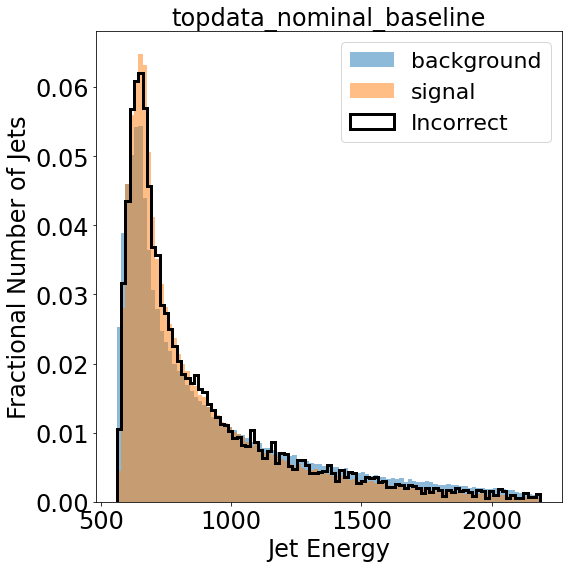

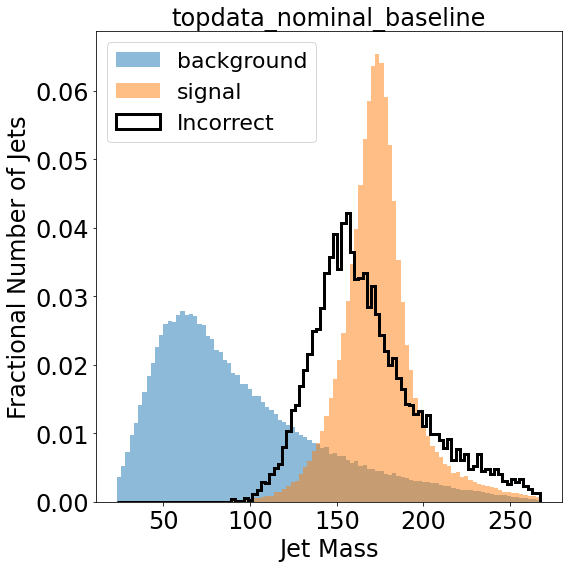

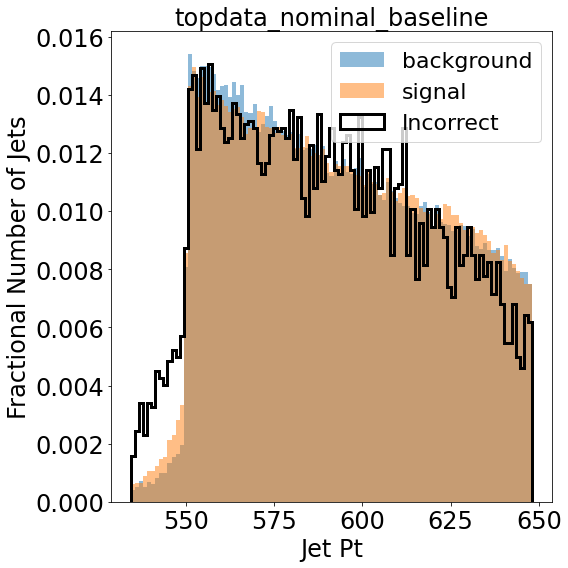

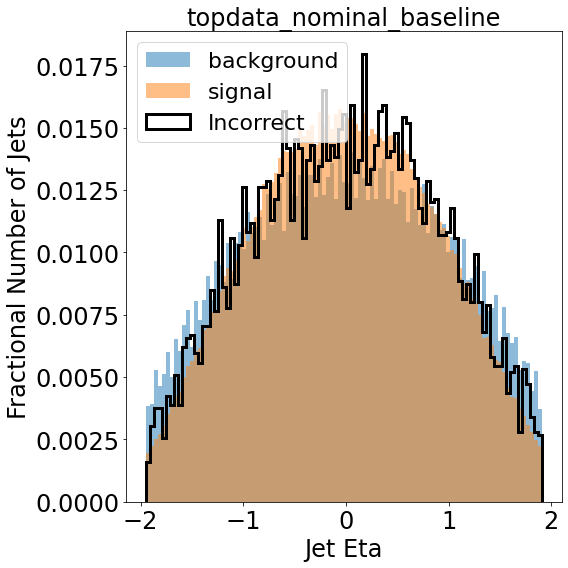

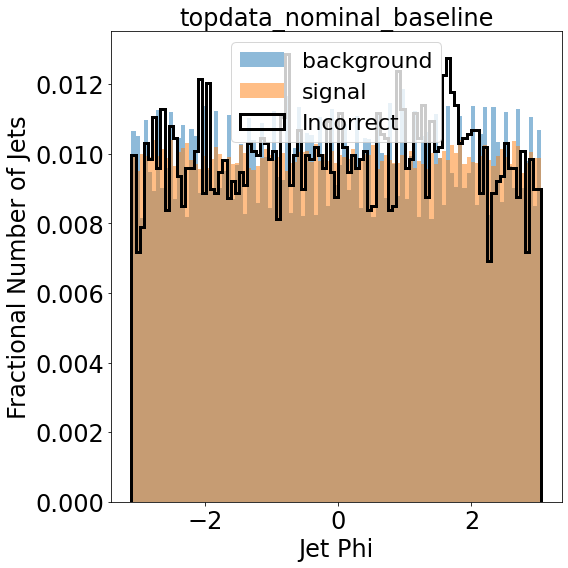

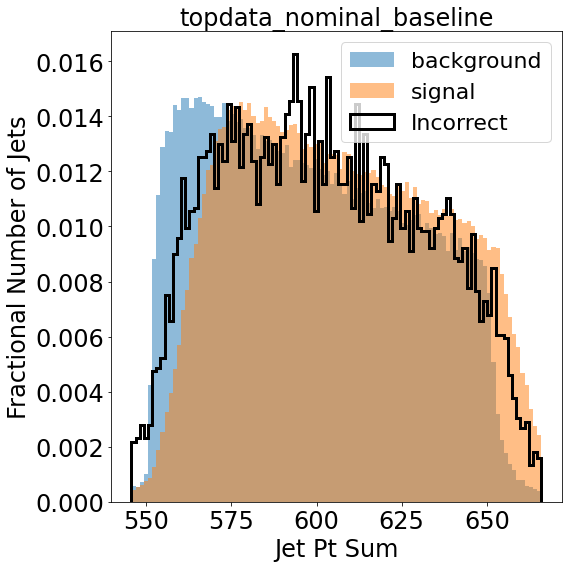

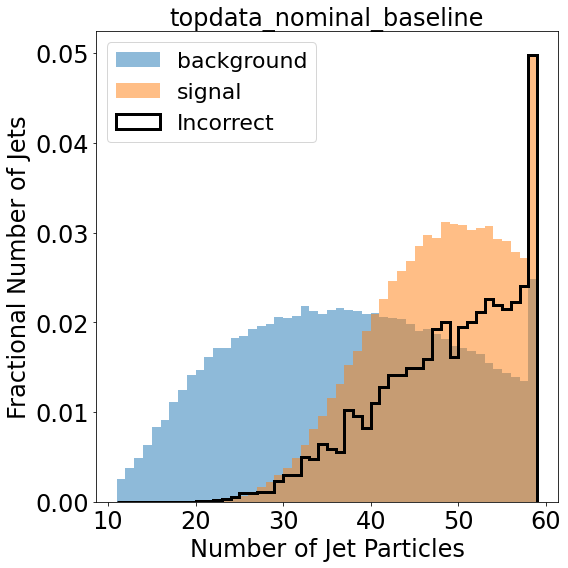

topdata_nominal_massmask200


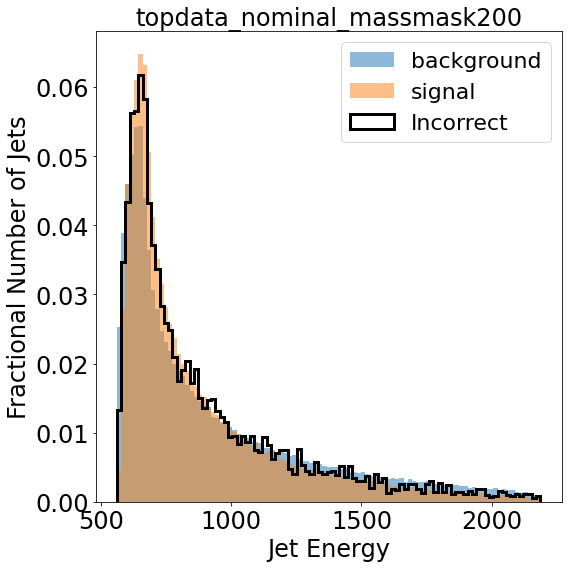

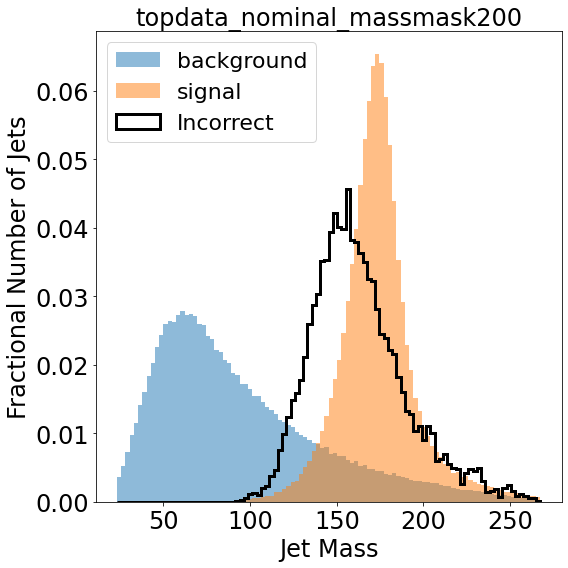

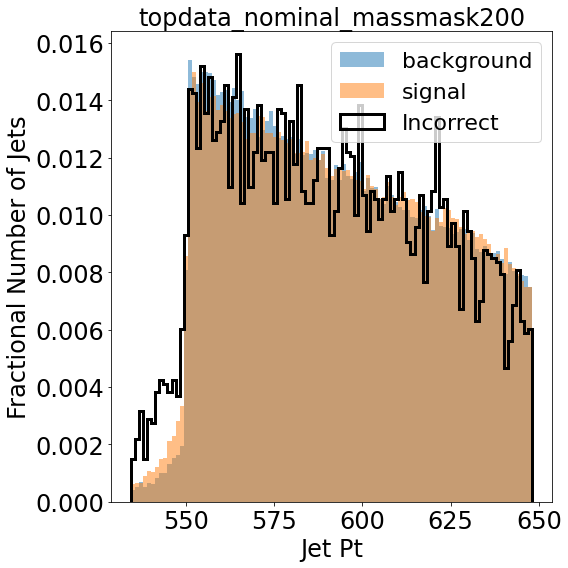

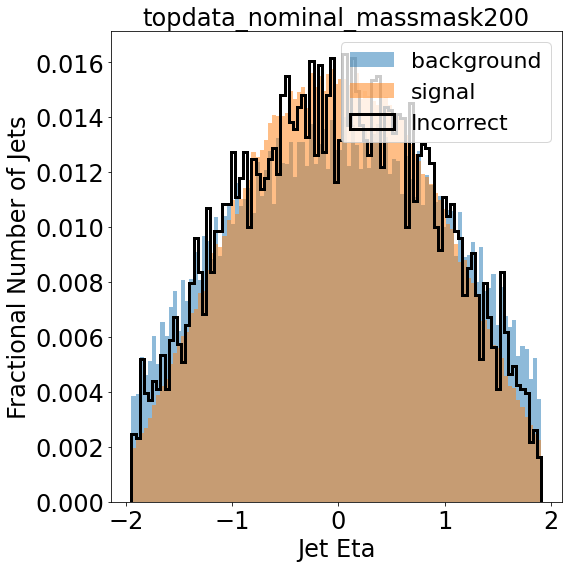

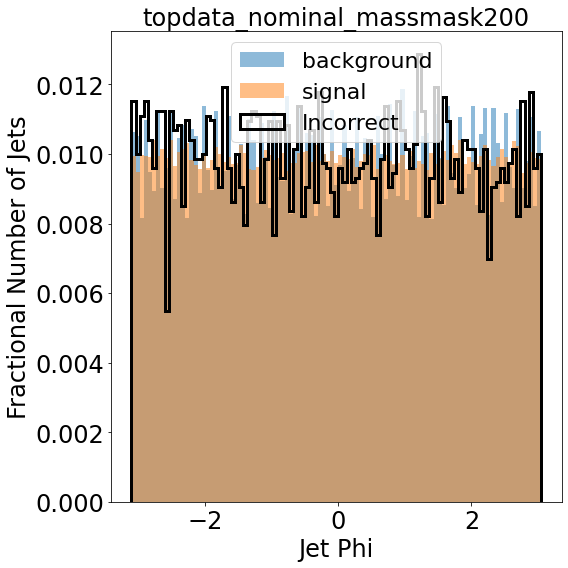

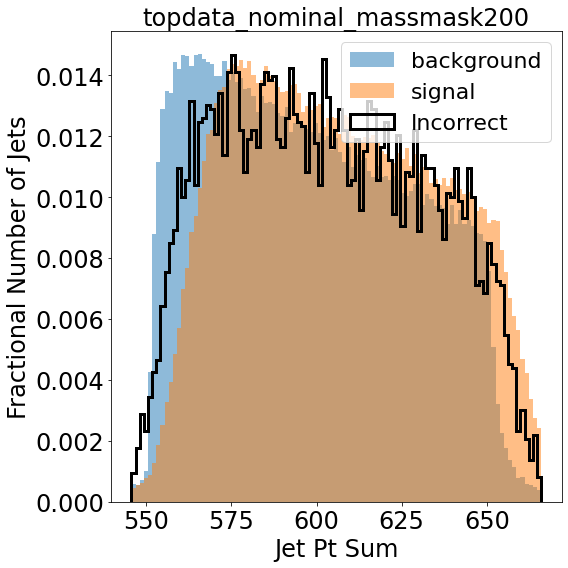

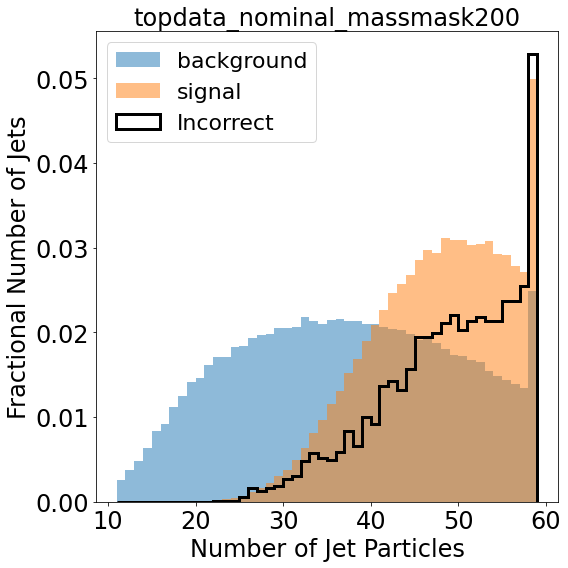

topdata_nominal_ptmask575


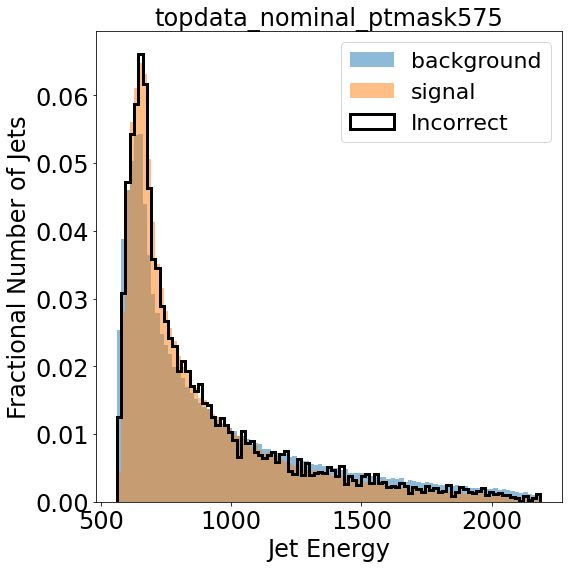

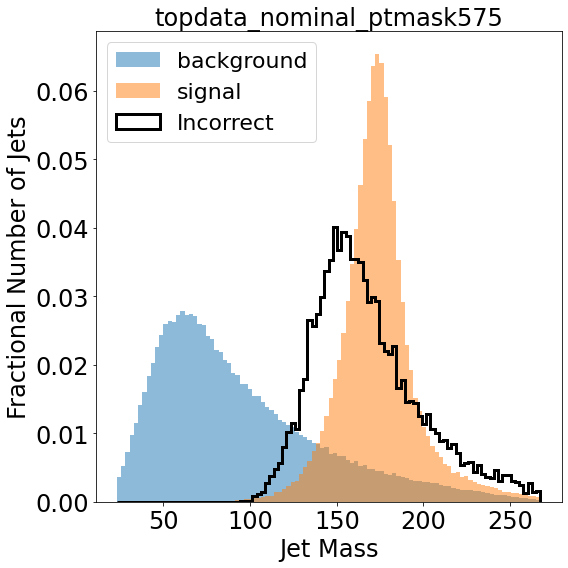

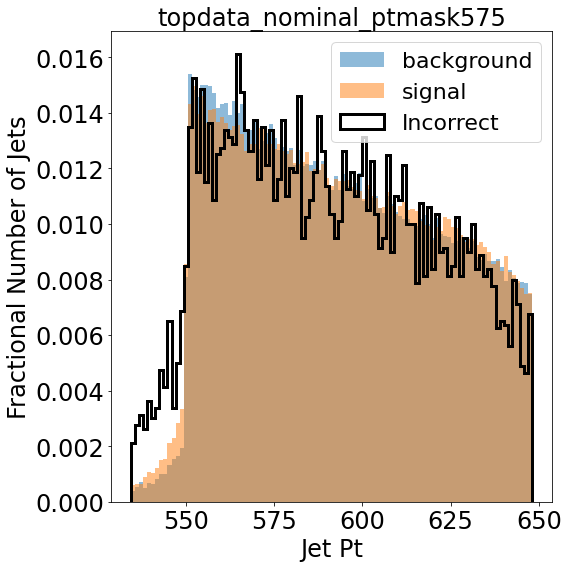

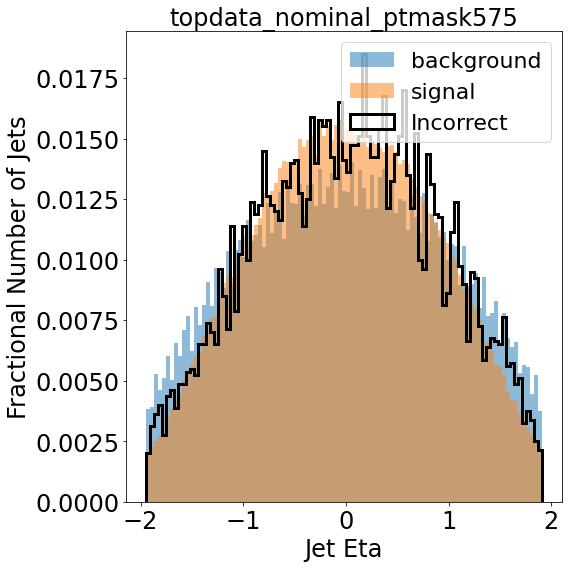

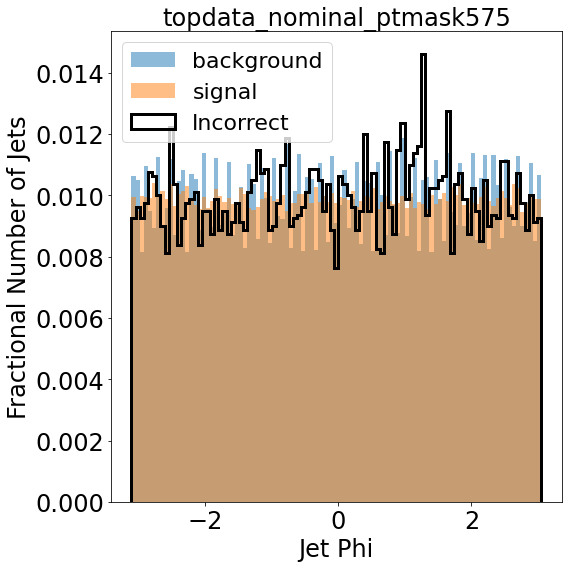

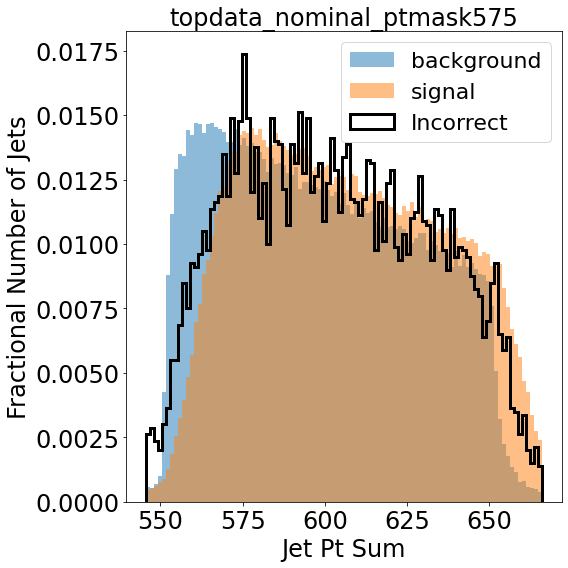

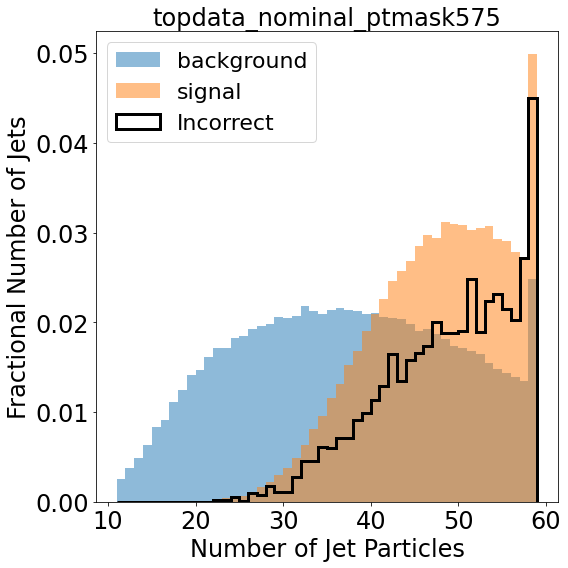

In [18]:
features = ['Jet Energy', 'Jet Mass', 'Jet Pt', 'Jet Eta', 'Jet Phi', 'Jet Pt Sum', 'Number of Jet Particles']
unc_thr = 0.8
fp_fn = False
only_EDL = True
nominal = True
nbins = 100

for ii,key in enumerate(all_keys):
    if only_EDL and ("MCDO" in key or "Ensemble" in key or ("nominal" not in key and nominal)):
        continue
    print(key)
    labels, preds, uncs = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['uncs']
    aug = model_results[key]['aug']
    for jj, f in enumerate(features):
        plt.figure(figsize=(8,8))
        mrs = []
        mls = []
        for i in range(len(names)):
            data = aug[labels == i, jj]
            mrs.append(np.percentile(data, 99.5))
            mls.append(np.percentile(data, 0.5))

        false_data = aug[(labels != preds) & (uncs > unc_thr), jj]

        mr = max(mrs)
        ml = min(mls)
        m = mr - ml
        if jj == 6:
            m = nbins
            
        for i in range(len(names)):
            bkg_data = aug[labels == i, jj]
            plt.hist(bkg_data, bins=np.arange(ml,mr,m/nbins), label=names[i], 
                     alpha=0.5, weights = (1./len(bkg_data)) * np.ones_like(bkg_data))
        if "topdata" in key and fp_fn:
            fp_indices_lu = (labels == 0) & (preds >= 0.5) & (uncs > unc_thr)
            fn_indices_lu = (labels == 1) & (preds < 0.5)  &  (uncs > unc_thr)
    
            fp_data = aug[fp_indices_lu, jj]
            fn_data = aug[fn_indices_lu, jj]
            
            plt.hist(fp_data, bins=np.arange(ml,mr,m/nbins), label="FP", 
                     color='black',  histtype='step', linewidth = 3, 
                     weights = (1./len(fp_data)) * np.ones_like(fp_data))
            plt.hist(fn_data, bins=np.arange(ml,mr,m/nbins), label="FN", 
                     color='maroon', histtype='step', linewidth = 3, 
                     weights = (1./len(fn_data)) * np.ones_like(fn_data))
            
        else:
            plt.hist(false_data, bins=np.arange(ml,mr,m/nbins), label='Incorrect', 
                     color='black',  histtype='step', linewidth = 3, 
                     weights = (1./len(false_data)) * np.ones_like(false_data))

        plt.xlabel(f, fontsize=24)
        plt.ylabel("Fractional Number of Jets", fontsize = 24)
        plt.title(key, fontsize = 24)
        plt.tick_params(axis='both', which='major', labelsize=24)
        plt.legend(fontsize = 22)
        plt.tight_layout()
        plt.show()
        #plt.savefig("figures/zpca_{}_{}.pdf".format(ii, label))

In [19]:
from sklearn.decomposition import PCA

#only works for EDL models
model2explore = "topdata_nominal_baseline"
labels, preds, uncs, latents = model_results[model2explore]['labels'], model_results[model2explore]['preds'], \
                               model_results[model2explore]['uncs'],   model_results[model2explore]['latents']


pca = PCA(n_components=0.99)
pca.fit(latents)

latents_pca = pca.fit_transform(latents)
latents_pca.shape

(404000, 37)

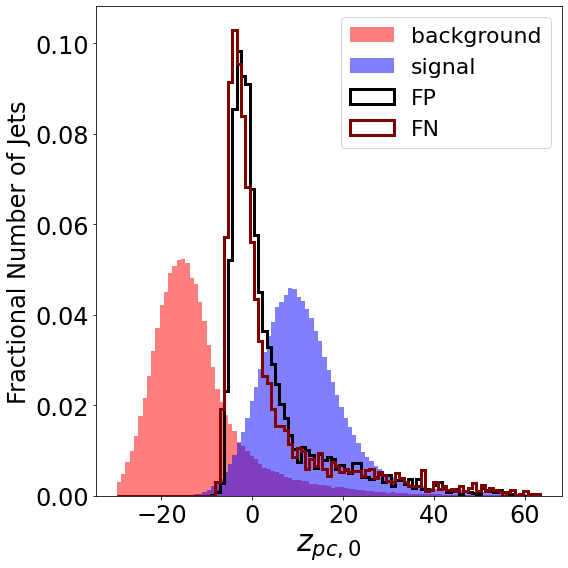

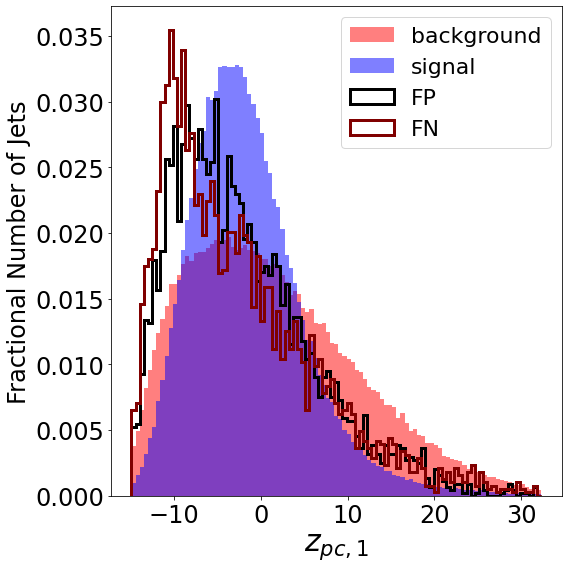

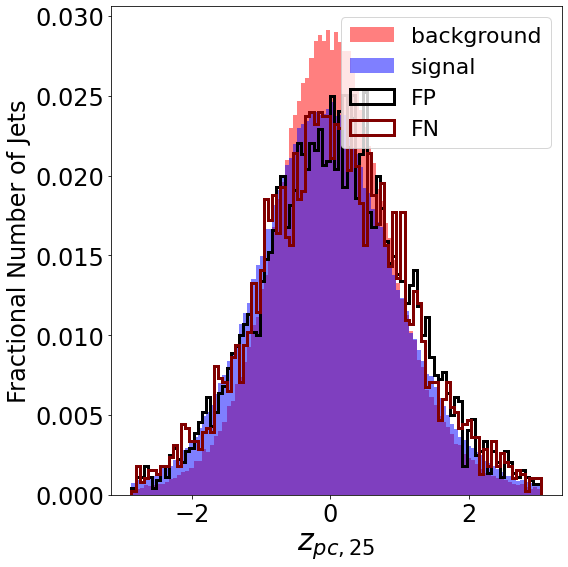

In [29]:
pc2plot = [0, 1, 25]
colors=['red', 'blue', 'green', 'orange', 'purple']
unc_thr = 0.8
fp_fn = True
nbins = 100

for ii in pc2plot:
    plt.figure(figsize=(8,8))
    mrs = []
    mls = []
    for i in range(len(names)):
        data = latents_pca[labels == i, ii]
        mrs.append(np.percentile(data, 99.5))
        mls.append(np.percentile(data, 0.5))

    false_data = latents_pca[(labels != preds) & (uncs > unc_thr), ii]
    
    mr = max(mrs)
    ml = min(mls)
    m = mr - ml
    for i in range(len(names)):
        bkg_data = latents_pca[labels == i, ii]
        plt.hist(bkg_data, bins=np.arange(ml,mr,m/nbins), label=names[i], 
                 color=colors[i], alpha=0.5, weights = (1./len(bkg_data)) * np.ones_like(bkg_data))
        
    if "topdata" in model2explore and fp_fn:
        fp_indices_lu = (labels == 0) & (preds >= 0.5) & (uncs > unc_thr)
        fn_indices_lu = (labels == 1) & (preds < 0.5)  &  (uncs > unc_thr)
        
        fp_data = latents_pca[fp_indices_lu, ii]
        fn_data = latents_pca[fn_indices_lu, ii]
    
        plt.hist(fp_data, bins=np.arange(ml,mr,m/nbins), label='FP', 
                 color='black',  histtype='step', linewidth = 3, 
                 weights = (1./len(fp_data)) * np.ones_like(fp_data))
        plt.hist(fn_data, bins=np.arange(ml,mr,m/nbins), label='FN', 
                 color='maroon', histtype='step', linewidth = 3, 
                 weights = (1./len(fn_data)) * np.ones_like(fn_data))    
    else:
        plt.hist(false_data, bins=np.arange(ml,mr,m/nbins), label='Incorrect', 
                 color='black',  histtype='step', linewidth = 3, 
                 weights = (1./len(false_data)) * np.ones_like(false_data))
    
    plt.xlabel('$z_{pc,' + '{}'.format(ii) + '}$', fontsize=30)
    plt.ylabel("Fractional Number of Jets", fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(fontsize = 22)
    plt.tight_layout()
    plt.show()
    #plt.savefig("figures/zpca_{}_{}.pdf".format(ii, label))

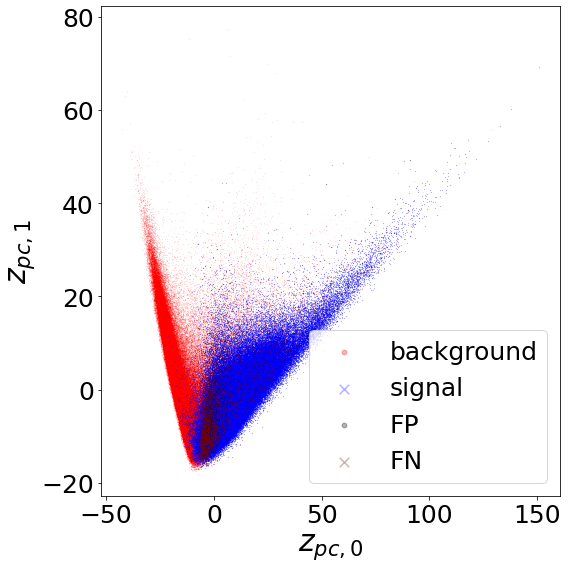

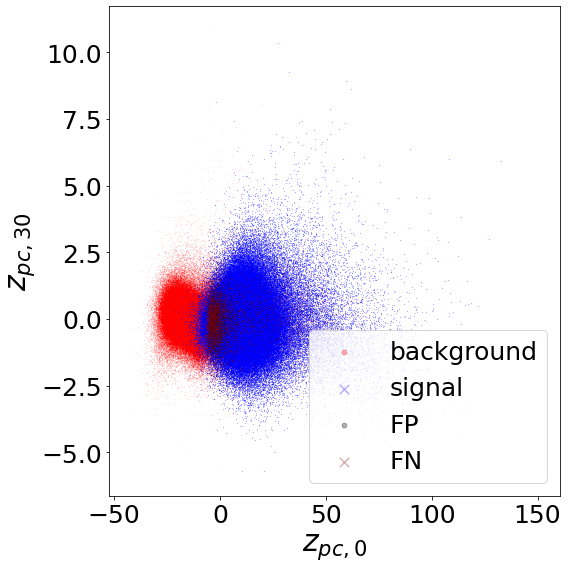

In [28]:
IDs = [(0,1), (0,30)]
Nsample = latents_pca.shape[0] # 30000
colors=['red', 'blue', 'green', 'orange', 'purple']
unc_thr = 0.8
fp_fn = True

#Nsample = 30000
if dataset != 'jetclass':
    markers = ['.', 'x', '.', 'x', '.']
else:
    markers = ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.']

for (idx1, idx2) in IDs:
    plt.figure(figsize = (8,8))
    
    false_indices = (labels != preds) & (uncs > unc_thr)
    for i in range(len(names)):
        indices = labels == i
        plt.scatter(latents_pca[indices, idx1][:Nsample], 
                latents_pca[indices, idx2][:Nsample], 
                color = colors[i], marker = markers[i], label = names[i], 
                alpha=0.3, s = 0.1, rasterized=True)
        
    if "topdata" in model2explore and fp_fn:
        fp_indices_lu = (labels == 0) & (preds >= 0.5) & (uncs > unc_thr)
        fn_indices_lu = (labels == 1) & (preds < 0.5)  &  (uncs > unc_thr)
            
        plt.scatter(latents_pca[fp_indices_lu, idx1][:Nsample], 
                latents_pca[fp_indices_lu, idx2][:Nsample], 
                color = 'black', marker = '.', label = 'FP', 
                alpha=0.3, s = 0.1, rasterized=True)
        plt.scatter(latents_pca[fn_indices_lu, idx1][:Nsample], 
                latents_pca[fn_indices_lu, idx2][:Nsample], 
                color = 'maroon', marker = 'x', label = 'FN', 
                alpha=0.3, s = 0.1, rasterized=True)   
    else:
        plt.scatter(latents_pca[false_indices, idx1][:Nsample], 
                latents_pca[false_indices, idx2][:Nsample], 
                color = 'black', marker = '.', label = 'Incorrect', 
                alpha=0.3, s = 0.1, rasterized=True)  
        
        
    plt.xlabel('$z_{pc,' + '{}'.format(idx1) + '}$', fontsize=30)
    plt.ylabel('$z_{pc,' + '{}'.format(idx2) + '}$', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.legend(loc = 'lower right', markerscale = 30, fontsize = 25)
    plt.tight_layout()
    plt.show()
